In [1]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
sub_cond_path = '/Users/liuq13/NODEAP_scripts/ProcessedData/SubConds.xlsx'
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [18]:
# Load and preprocess
all_corr_data, all_tms_type, all_subject_id, all_stimloc = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix_w_sphere.mat',
                                                               key_name='correlation_matrix')
X_tensor = preprocess_for_torch(all_corr_data)


[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_30/S3D2/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_44/S1D1/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_83/S3D1/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_87/D0/conn_matrix_w_sphere.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_88/D0/conn_matrix_w_sphere.mat
Columns with NaN: 56 / 464
Tensor shape after preprocessing: torch.Size([331, 408])


In [22]:
condition_list = np.array([condition_map[t] for t in all_tms_type]) # map tms type to 0,1,2
condition_tensor = torch.tensor(condition_list, dtype=torch.long)

# Create unique key: subject + condition
combo_keys = np.array([f"{s}_{c}" for s, c in zip(all_subject_id, condition_list)])
combo_counts = Counter(combo_keys)

weights = np.array([1.0 / combo_counts[k] for k in combo_keys]) # assign weights based on counts
weights_tensor = torch.DoubleTensor(weights) # convert to torch tensor

le = LabelEncoder()
subject_labels = le.fit_transform(all_subject_id)
subject_tensor = torch.tensor(subject_labels, dtype=torch.long)

In [23]:
dataset = TensorDataset(X_tensor, subject_tensor, condition_tensor)
# create a weighted sampler that draws samples w/ prob proportional to weight
sampler = WeightedRandomSampler(weights_tensor, num_samples=len(weights_tensor), replacement=True)
# create a dataloader using the sampler instead of random shuffle
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

In [24]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
latent_dim = 10
NUM_EPOCH = 500
LR = 3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=device, epochs=NUM_EPOCH)


===== Epoch 1 =====


Epoch 1/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 183.59it/s]


Epoch 1, Loss: 433.0252, Recon: 432.6108, KL: 0.4144

===== Epoch 2 =====


Epoch 2/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 508.57it/s]


Epoch 2, Loss: 391.3207, Recon: 390.6189, KL: 0.7018

===== Epoch 3 =====


Epoch 3/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 806.51it/s]


Epoch 3, Loss: 379.3908, Recon: 378.0192, KL: 1.3715

===== Epoch 4 =====


Epoch 4/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 755.03it/s]


Epoch 4, Loss: 373.3684, Recon: 370.2009, KL: 3.1674

===== Epoch 5 =====


Epoch 5/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 695.19it/s]


Epoch 5, Loss: 376.2631, Recon: 369.6306, KL: 6.6325

===== Epoch 6 =====


Epoch 6/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 797.20it/s]


Epoch 6, Loss: 328.4722, Recon: 317.5726, KL: 10.8996

===== Epoch 7 =====


Epoch 7/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 809.84it/s]


Epoch 7, Loss: 316.9570, Recon: 304.0843, KL: 12.8727

===== Epoch 8 =====


Epoch 8/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 849.49it/s]


Epoch 8, Loss: 304.3482, Recon: 288.0099, KL: 16.3382

===== Epoch 9 =====


Epoch 9/500: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 797.80it/s]


Epoch 9, Loss: 286.2085, Recon: 268.2668, KL: 17.9417

===== Epoch 10 =====


Epoch 10/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 758.58it/s]


Epoch 10, Loss: 272.7801, Recon: 254.2544, KL: 18.5257

===== Epoch 11 =====


Epoch 11/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 837.20it/s]


Epoch 11, Loss: 254.3736, Recon: 235.0046, KL: 19.3690

===== Epoch 12 =====


Epoch 12/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 805.05it/s]


Epoch 12, Loss: 254.2411, Recon: 233.9746, KL: 20.2666

===== Epoch 13 =====


Epoch 13/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 805.98it/s]


Epoch 13, Loss: 232.1818, Recon: 210.9196, KL: 21.2622

===== Epoch 14 =====


Epoch 14/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 732.99it/s]


Epoch 14, Loss: 230.2844, Recon: 208.9367, KL: 21.3477

===== Epoch 15 =====


Epoch 15/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 753.68it/s]


Epoch 15, Loss: 233.9509, Recon: 211.3950, KL: 22.5559

===== Epoch 16 =====


Epoch 16/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 777.70it/s]


Epoch 16, Loss: 212.4217, Recon: 190.7550, KL: 21.6666

===== Epoch 17 =====


Epoch 17/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 851.32it/s]


Epoch 17, Loss: 221.1753, Recon: 198.1508, KL: 23.0245

===== Epoch 18 =====


Epoch 18/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 823.06it/s]


Epoch 18, Loss: 219.1151, Recon: 195.8355, KL: 23.2796

===== Epoch 19 =====


Epoch 19/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 785.44it/s]


Epoch 19, Loss: 208.0008, Recon: 185.5184, KL: 22.4824

===== Epoch 20 =====


Epoch 20/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 834.14it/s]


Epoch 20, Loss: 201.2614, Recon: 178.4928, KL: 22.7686

===== Epoch 21 =====


Epoch 21/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 777.00it/s]


Epoch 21, Loss: 210.4101, Recon: 187.2387, KL: 23.1715

===== Epoch 22 =====


Epoch 22/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 792.67it/s]


Epoch 22, Loss: 208.1876, Recon: 185.8253, KL: 22.3622

===== Epoch 23 =====


Epoch 23/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 835.22it/s]


Epoch 23, Loss: 195.3853, Recon: 172.3605, KL: 23.0248

===== Epoch 24 =====


Epoch 24/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 758.36it/s]


Epoch 24, Loss: 198.2434, Recon: 174.3633, KL: 23.8801

===== Epoch 25 =====


Epoch 25/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 832.32it/s]


Epoch 25, Loss: 192.6229, Recon: 169.6511, KL: 22.9719

===== Epoch 26 =====


Epoch 26/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 758.36it/s]


Epoch 26, Loss: 191.7954, Recon: 168.6016, KL: 23.1938

===== Epoch 27 =====


Epoch 27/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 771.66it/s]


Epoch 27, Loss: 188.4798, Recon: 164.9889, KL: 23.4909

===== Epoch 28 =====


Epoch 28/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 807.15it/s]


Epoch 28, Loss: 197.2057, Recon: 173.9910, KL: 23.2147

===== Epoch 29 =====


Epoch 29/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 862.35it/s]


Epoch 29, Loss: 198.9859, Recon: 174.7260, KL: 24.2599

===== Epoch 30 =====


Epoch 30/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 898.91it/s]


Epoch 30, Loss: 194.7080, Recon: 171.7638, KL: 22.9442

===== Epoch 31 =====


Epoch 31/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 897.88it/s]


Epoch 31, Loss: 178.4339, Recon: 155.2173, KL: 23.2166

===== Epoch 32 =====


Epoch 32/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 974.92it/s]


Epoch 32, Loss: 181.2247, Recon: 158.7439, KL: 22.4808

===== Epoch 33 =====


Epoch 33/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 847.26it/s]


Epoch 33, Loss: 183.7970, Recon: 160.8132, KL: 22.9838

===== Epoch 34 =====


Epoch 34/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 905.43it/s]


Epoch 34, Loss: 182.1807, Recon: 159.4330, KL: 22.7477

===== Epoch 35 =====


Epoch 35/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 872.61it/s]


Epoch 35, Loss: 182.4365, Recon: 159.9272, KL: 22.5092

===== Epoch 36 =====


Epoch 36/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 816.01it/s]


Epoch 36, Loss: 176.8347, Recon: 153.6454, KL: 23.1893

===== Epoch 37 =====


Epoch 37/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 566.95it/s]


Epoch 37, Loss: 177.9580, Recon: 154.4520, KL: 23.5060

===== Epoch 38 =====


Epoch 38/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 873.71it/s]


Epoch 38, Loss: 179.5317, Recon: 156.3570, KL: 23.1746

===== Epoch 39 =====


Epoch 39/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 861.00it/s]


Epoch 39, Loss: 179.1347, Recon: 156.7178, KL: 22.4170

===== Epoch 40 =====


Epoch 40/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 914.23it/s]


Epoch 40, Loss: 173.8773, Recon: 150.9653, KL: 22.9120

===== Epoch 41 =====


Epoch 41/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 536.74it/s]


Epoch 41, Loss: 174.1989, Recon: 150.9324, KL: 23.2664

===== Epoch 42 =====


Epoch 42/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 643.83it/s]


Epoch 42, Loss: 171.6967, Recon: 148.8313, KL: 22.8654

===== Epoch 43 =====


Epoch 43/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 544.59it/s]


Epoch 43, Loss: 174.0913, Recon: 150.7133, KL: 23.3780

===== Epoch 44 =====


Epoch 44/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 779.03it/s]


Epoch 44, Loss: 175.4160, Recon: 152.2453, KL: 23.1706

===== Epoch 45 =====


Epoch 45/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 718.35it/s]


Epoch 45, Loss: 165.9419, Recon: 142.8132, KL: 23.1287

===== Epoch 46 =====


Epoch 46/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 614.50it/s]


Epoch 46, Loss: 169.7075, Recon: 146.6322, KL: 23.0753

===== Epoch 47 =====


Epoch 47/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 622.46it/s]


Epoch 47, Loss: 165.9024, Recon: 143.0474, KL: 22.8550

===== Epoch 48 =====


Epoch 48/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 520.00it/s]


Epoch 48, Loss: 170.8997, Recon: 147.5765, KL: 23.3232

===== Epoch 49 =====


Epoch 49/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 683.95it/s]


Epoch 49, Loss: 166.6681, Recon: 144.2068, KL: 22.4612

===== Epoch 50 =====


Epoch 50/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 576.94it/s]


Epoch 50, Loss: 164.1886, Recon: 141.3594, KL: 22.8292

===== Epoch 51 =====


Epoch 51/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 753.23it/s]


Epoch 51, Loss: 172.8519, Recon: 149.4242, KL: 23.4277

===== Epoch 52 =====


Epoch 52/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 777.34it/s]


Epoch 52, Loss: 164.6870, Recon: 141.4671, KL: 23.2199

===== Epoch 53 =====


Epoch 53/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 724.68it/s]


Epoch 53, Loss: 164.9105, Recon: 142.2206, KL: 22.6899

===== Epoch 54 =====


Epoch 54/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 776.24it/s]


Epoch 54, Loss: 167.1686, Recon: 144.4771, KL: 22.6915

===== Epoch 55 =====


Epoch 55/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 718.30it/s]


Epoch 55, Loss: 167.1874, Recon: 143.9644, KL: 23.2231

===== Epoch 56 =====


Epoch 56/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 786.15it/s]


Epoch 56, Loss: 165.1013, Recon: 141.7067, KL: 23.3945

===== Epoch 57 =====


Epoch 57/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 792.59it/s]


Epoch 57, Loss: 164.7970, Recon: 141.7148, KL: 23.0822

===== Epoch 58 =====


Epoch 58/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 734.60it/s]


Epoch 58, Loss: 164.6159, Recon: 140.9450, KL: 23.6709

===== Epoch 59 =====


Epoch 59/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 785.00it/s]


Epoch 59, Loss: 164.1668, Recon: 140.8425, KL: 23.3243

===== Epoch 60 =====


Epoch 60/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 779.25it/s]


Epoch 60, Loss: 162.6732, Recon: 139.3264, KL: 23.3468

===== Epoch 61 =====


Epoch 61/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 823.16it/s]


Epoch 61, Loss: 164.1880, Recon: 140.9750, KL: 23.2131

===== Epoch 62 =====


Epoch 62/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 781.98it/s]


Epoch 62, Loss: 161.5114, Recon: 138.8749, KL: 22.6365

===== Epoch 63 =====


Epoch 63/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 932.35it/s]


Epoch 63, Loss: 164.8567, Recon: 141.3922, KL: 23.4645

===== Epoch 64 =====


Epoch 64/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 777.99it/s]


Epoch 64, Loss: 159.2310, Recon: 135.1108, KL: 24.1202

===== Epoch 65 =====


Epoch 65/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 700.99it/s]


Epoch 65, Loss: 154.4230, Recon: 131.3194, KL: 23.1035

===== Epoch 66 =====


Epoch 66/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 730.23it/s]


Epoch 66, Loss: 159.0489, Recon: 135.0976, KL: 23.9513

===== Epoch 67 =====


Epoch 67/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 732.11it/s]


Epoch 67, Loss: 157.7225, Recon: 133.9492, KL: 23.7733

===== Epoch 68 =====


Epoch 68/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 676.30it/s]


Epoch 68, Loss: 155.0373, Recon: 131.5072, KL: 23.5301

===== Epoch 69 =====


Epoch 69/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 791.88it/s]


Epoch 69, Loss: 157.5734, Recon: 133.9012, KL: 23.6722

===== Epoch 70 =====


Epoch 70/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 804.33it/s]


Epoch 70, Loss: 156.3099, Recon: 132.7634, KL: 23.5465

===== Epoch 71 =====


Epoch 71/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 624.42it/s]


Epoch 71, Loss: 155.6510, Recon: 132.0084, KL: 23.6427

===== Epoch 72 =====


Epoch 72/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 732.05it/s]


Epoch 72, Loss: 154.7435, Recon: 131.4191, KL: 23.3244

===== Epoch 73 =====


Epoch 73/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 751.68it/s]


Epoch 73, Loss: 152.1130, Recon: 128.4985, KL: 23.6146

===== Epoch 74 =====


Epoch 74/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 736.23it/s]


Epoch 74, Loss: 148.7165, Recon: 124.3210, KL: 24.3955

===== Epoch 75 =====


Epoch 75/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 713.23it/s]


Epoch 75, Loss: 152.2839, Recon: 128.4205, KL: 23.8634

===== Epoch 76 =====


Epoch 76/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 707.93it/s]


Epoch 76, Loss: 156.2059, Recon: 131.2479, KL: 24.9580

===== Epoch 77 =====


Epoch 77/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 681.91it/s]


Epoch 77, Loss: 149.7659, Recon: 126.7795, KL: 22.9864

===== Epoch 78 =====


Epoch 78/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 748.51it/s]


Epoch 78, Loss: 148.3362, Recon: 124.4551, KL: 23.8811

===== Epoch 79 =====


Epoch 79/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 788.63it/s]


Epoch 79, Loss: 152.3582, Recon: 128.4944, KL: 23.8638

===== Epoch 80 =====


Epoch 80/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 547.83it/s]


Epoch 80, Loss: 146.7390, Recon: 123.6946, KL: 23.0445

===== Epoch 81 =====


Epoch 81/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 608.70it/s]


Epoch 81, Loss: 156.4304, Recon: 132.4549, KL: 23.9755

===== Epoch 82 =====


Epoch 82/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 601.59it/s]


Epoch 82, Loss: 151.7973, Recon: 126.5724, KL: 25.2249

===== Epoch 83 =====


Epoch 83/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 795.42it/s]


Epoch 83, Loss: 153.2923, Recon: 128.8072, KL: 24.4851

===== Epoch 84 =====


Epoch 84/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 823.91it/s]


Epoch 84, Loss: 149.8435, Recon: 125.1838, KL: 24.6597

===== Epoch 85 =====


Epoch 85/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 779.93it/s]


Epoch 85, Loss: 151.1126, Recon: 126.9560, KL: 24.1566

===== Epoch 86 =====


Epoch 86/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 785.61it/s]


Epoch 86, Loss: 151.5497, Recon: 127.2344, KL: 24.3152

===== Epoch 87 =====


Epoch 87/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 766.57it/s]


Epoch 87, Loss: 146.6106, Recon: 122.8178, KL: 23.7927

===== Epoch 88 =====


Epoch 88/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 761.87it/s]


Epoch 88, Loss: 150.1196, Recon: 125.9369, KL: 24.1826

===== Epoch 89 =====


Epoch 89/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 795.72it/s]


Epoch 89, Loss: 144.3083, Recon: 121.0300, KL: 23.2783

===== Epoch 90 =====


Epoch 90/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 831.36it/s]


Epoch 90, Loss: 148.0899, Recon: 123.7140, KL: 24.3759

===== Epoch 91 =====


Epoch 91/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 802.92it/s]


Epoch 91, Loss: 144.2048, Recon: 120.1720, KL: 24.0328

===== Epoch 92 =====


Epoch 92/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 827.07it/s]


Epoch 92, Loss: 145.3428, Recon: 121.6833, KL: 23.6595

===== Epoch 93 =====


Epoch 93/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 838.28it/s]


Epoch 93, Loss: 145.2390, Recon: 121.0963, KL: 24.1427

===== Epoch 94 =====


Epoch 94/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 847.19it/s]


Epoch 94, Loss: 140.1291, Recon: 115.9797, KL: 24.1494

===== Epoch 95 =====


Epoch 95/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 784.32it/s]


Epoch 95, Loss: 141.4874, Recon: 116.7542, KL: 24.7332

===== Epoch 96 =====


Epoch 96/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 886.47it/s]


Epoch 96, Loss: 146.0640, Recon: 121.9577, KL: 24.1063

===== Epoch 97 =====


Epoch 97/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 926.14it/s]


Epoch 97, Loss: 144.8513, Recon: 120.1862, KL: 24.6651

===== Epoch 98 =====


Epoch 98/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 871.44it/s]


Epoch 98, Loss: 138.0826, Recon: 113.9233, KL: 24.1593

===== Epoch 99 =====


Epoch 99/500: 100%|██████████████████████████████████████████████████| 11/11 [00:00<00:00, 789.27it/s]


Epoch 99, Loss: 139.0208, Recon: 114.2265, KL: 24.7943

===== Epoch 100 =====


Epoch 100/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 796.64it/s]


Epoch 100, Loss: 145.2279, Recon: 120.2998, KL: 24.9281

===== Epoch 101 =====


Epoch 101/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 648.05it/s]


Epoch 101, Loss: 145.7066, Recon: 121.5609, KL: 24.1457

===== Epoch 102 =====


Epoch 102/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 690.60it/s]


Epoch 102, Loss: 144.2820, Recon: 119.5714, KL: 24.7106

===== Epoch 103 =====


Epoch 103/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 742.45it/s]


Epoch 103, Loss: 143.6247, Recon: 119.3599, KL: 24.2647

===== Epoch 104 =====


Epoch 104/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 760.51it/s]


Epoch 104, Loss: 141.3306, Recon: 116.7107, KL: 24.6198

===== Epoch 105 =====


Epoch 105/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 682.17it/s]


Epoch 105, Loss: 141.6483, Recon: 117.2809, KL: 24.3673

===== Epoch 106 =====


Epoch 106/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 741.63it/s]


Epoch 106, Loss: 141.1197, Recon: 116.8886, KL: 24.2312

===== Epoch 107 =====


Epoch 107/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 800.25it/s]


Epoch 107, Loss: 143.0762, Recon: 118.2801, KL: 24.7961

===== Epoch 108 =====


Epoch 108/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 791.87it/s]


Epoch 108, Loss: 141.3117, Recon: 116.9291, KL: 24.3825

===== Epoch 109 =====


Epoch 109/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 592.58it/s]


Epoch 109, Loss: 142.8765, Recon: 118.4013, KL: 24.4753

===== Epoch 110 =====


Epoch 110/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 664.77it/s]


Epoch 110, Loss: 138.6665, Recon: 113.8794, KL: 24.7871

===== Epoch 111 =====


Epoch 111/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 723.84it/s]


Epoch 111, Loss: 140.8178, Recon: 117.2495, KL: 23.5683

===== Epoch 112 =====


Epoch 112/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 694.14it/s]


Epoch 112, Loss: 139.0795, Recon: 114.6005, KL: 24.4790

===== Epoch 113 =====


Epoch 113/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 713.26it/s]


Epoch 113, Loss: 140.8375, Recon: 115.7775, KL: 25.0600

===== Epoch 114 =====


Epoch 114/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 789.14it/s]


Epoch 114, Loss: 136.9197, Recon: 111.7839, KL: 25.1358

===== Epoch 115 =====


Epoch 115/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 697.83it/s]


Epoch 115, Loss: 141.8149, Recon: 116.7157, KL: 25.0992

===== Epoch 116 =====


Epoch 116/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 714.16it/s]


Epoch 116, Loss: 141.6737, Recon: 116.7547, KL: 24.9190

===== Epoch 117 =====


Epoch 117/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 819.07it/s]


Epoch 117, Loss: 139.9098, Recon: 116.3109, KL: 23.5989

===== Epoch 118 =====


Epoch 118/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 724.78it/s]


Epoch 118, Loss: 134.5024, Recon: 109.4549, KL: 25.0475

===== Epoch 119 =====


Epoch 119/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 802.79it/s]


Epoch 119, Loss: 135.4573, Recon: 109.9763, KL: 25.4811

===== Epoch 120 =====


Epoch 120/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 840.54it/s]


Epoch 120, Loss: 136.6170, Recon: 111.1793, KL: 25.4378

===== Epoch 121 =====


Epoch 121/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 768.43it/s]


Epoch 121, Loss: 137.8172, Recon: 112.6536, KL: 25.1636

===== Epoch 122 =====


Epoch 122/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 624.68it/s]


Epoch 122, Loss: 137.5330, Recon: 112.0877, KL: 25.4454

===== Epoch 123 =====


Epoch 123/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 685.96it/s]


Epoch 123, Loss: 137.8358, Recon: 113.6127, KL: 24.2231

===== Epoch 124 =====


Epoch 124/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 787.90it/s]


Epoch 124, Loss: 140.2356, Recon: 115.6686, KL: 24.5670

===== Epoch 125 =====


Epoch 125/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 754.35it/s]


Epoch 125, Loss: 136.4353, Recon: 111.3747, KL: 25.0606

===== Epoch 126 =====


Epoch 126/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 774.10it/s]


Epoch 126, Loss: 136.4056, Recon: 111.2862, KL: 25.1194

===== Epoch 127 =====


Epoch 127/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 731.92it/s]


Epoch 127, Loss: 133.1362, Recon: 108.2974, KL: 24.8389

===== Epoch 128 =====


Epoch 128/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 743.74it/s]


Epoch 128, Loss: 136.0131, Recon: 111.3020, KL: 24.7111

===== Epoch 129 =====


Epoch 129/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 945.75it/s]


Epoch 129, Loss: 138.6442, Recon: 114.0320, KL: 24.6122

===== Epoch 130 =====


Epoch 130/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 873.15it/s]


Epoch 130, Loss: 132.7497, Recon: 108.2551, KL: 24.4946

===== Epoch 131 =====


Epoch 131/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 753.12it/s]


Epoch 131, Loss: 133.4032, Recon: 108.5301, KL: 24.8730

===== Epoch 132 =====


Epoch 132/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 822.24it/s]


Epoch 132, Loss: 135.1375, Recon: 111.0108, KL: 24.1267

===== Epoch 133 =====


Epoch 133/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 798.14it/s]


Epoch 133, Loss: 131.6330, Recon: 106.1995, KL: 25.4335

===== Epoch 134 =====


Epoch 134/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 821.75it/s]


Epoch 134, Loss: 134.5128, Recon: 109.7407, KL: 24.7721

===== Epoch 135 =====


Epoch 135/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 827.56it/s]


Epoch 135, Loss: 136.3648, Recon: 112.0055, KL: 24.3594

===== Epoch 136 =====


Epoch 136/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 844.02it/s]


Epoch 136, Loss: 134.0439, Recon: 109.7172, KL: 24.3267

===== Epoch 137 =====


Epoch 137/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 839.24it/s]


Epoch 137, Loss: 130.0748, Recon: 104.4142, KL: 25.6606

===== Epoch 138 =====


Epoch 138/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 817.43it/s]


Epoch 138, Loss: 131.5282, Recon: 106.4505, KL: 25.0777

===== Epoch 139 =====


Epoch 139/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 815.42it/s]


Epoch 139, Loss: 133.3453, Recon: 109.4239, KL: 23.9214

===== Epoch 140 =====


Epoch 140/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 818.58it/s]


Epoch 140, Loss: 130.1422, Recon: 105.7672, KL: 24.3750

===== Epoch 141 =====


Epoch 141/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 775.53it/s]


Epoch 141, Loss: 131.5211, Recon: 106.2806, KL: 25.2405

===== Epoch 142 =====


Epoch 142/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 795.38it/s]


Epoch 142, Loss: 132.1452, Recon: 107.8632, KL: 24.2820

===== Epoch 143 =====


Epoch 143/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 808.82it/s]


Epoch 143, Loss: 132.2488, Recon: 107.4246, KL: 24.8241

===== Epoch 144 =====


Epoch 144/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 628.39it/s]


Epoch 144, Loss: 132.7686, Recon: 107.8872, KL: 24.8814

===== Epoch 145 =====


Epoch 145/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 834.14it/s]


Epoch 145, Loss: 130.4653, Recon: 105.5386, KL: 24.9267

===== Epoch 146 =====


Epoch 146/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 778.32it/s]


Epoch 146, Loss: 134.4937, Recon: 110.0705, KL: 24.4231

===== Epoch 147 =====


Epoch 147/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 814.28it/s]


Epoch 147, Loss: 132.1338, Recon: 107.2542, KL: 24.8796

===== Epoch 148 =====


Epoch 148/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 745.51it/s]


Epoch 148, Loss: 129.6980, Recon: 104.3434, KL: 25.3547

===== Epoch 149 =====


Epoch 149/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 753.16it/s]


Epoch 149, Loss: 129.6095, Recon: 104.8794, KL: 24.7301

===== Epoch 150 =====


Epoch 150/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 798.72it/s]


Epoch 150, Loss: 125.9760, Recon: 101.3236, KL: 24.6524

===== Epoch 151 =====


Epoch 151/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 758.68it/s]


Epoch 151, Loss: 128.6049, Recon: 103.4850, KL: 25.1199

===== Epoch 152 =====


Epoch 152/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 822.74it/s]


Epoch 152, Loss: 130.0728, Recon: 105.3059, KL: 24.7669

===== Epoch 153 =====


Epoch 153/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 812.05it/s]


Epoch 153, Loss: 131.9300, Recon: 107.5762, KL: 24.3538

===== Epoch 154 =====


Epoch 154/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 834.85it/s]


Epoch 154, Loss: 129.2335, Recon: 104.5480, KL: 24.6855

===== Epoch 155 =====


Epoch 155/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 807.40it/s]


Epoch 155, Loss: 133.2410, Recon: 109.1087, KL: 24.1323

===== Epoch 156 =====


Epoch 156/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 907.66it/s]


Epoch 156, Loss: 127.9830, Recon: 102.9603, KL: 25.0227

===== Epoch 157 =====


Epoch 157/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 757.68it/s]


Epoch 157, Loss: 129.4339, Recon: 104.5626, KL: 24.8713

===== Epoch 158 =====


Epoch 158/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 879.43it/s]


Epoch 158, Loss: 131.2086, Recon: 104.8648, KL: 26.3437

===== Epoch 159 =====


Epoch 159/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 742.03it/s]


Epoch 159, Loss: 126.6033, Recon: 102.4269, KL: 24.1764

===== Epoch 160 =====


Epoch 160/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 794.18it/s]


Epoch 160, Loss: 127.6899, Recon: 103.1155, KL: 24.5744

===== Epoch 161 =====


Epoch 161/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 678.98it/s]


Epoch 161, Loss: 126.1156, Recon: 100.4580, KL: 25.6577

===== Epoch 162 =====


Epoch 162/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 822.93it/s]


Epoch 162, Loss: 131.2309, Recon: 105.5563, KL: 25.6746

===== Epoch 163 =====


Epoch 163/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 876.44it/s]


Epoch 163, Loss: 129.0123, Recon: 104.5822, KL: 24.4301

===== Epoch 164 =====


Epoch 164/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 833.86it/s]


Epoch 164, Loss: 133.9890, Recon: 108.3202, KL: 25.6688

===== Epoch 165 =====


Epoch 165/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 755.54it/s]


Epoch 165, Loss: 129.5440, Recon: 104.2425, KL: 25.3015

===== Epoch 166 =====


Epoch 166/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 793.94it/s]


Epoch 166, Loss: 129.3766, Recon: 103.1959, KL: 26.1807

===== Epoch 167 =====


Epoch 167/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 881.83it/s]


Epoch 167, Loss: 128.5976, Recon: 104.7505, KL: 23.8471

===== Epoch 168 =====


Epoch 168/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 777.12it/s]


Epoch 168, Loss: 124.7909, Recon: 99.3344, KL: 25.4565

===== Epoch 169 =====


Epoch 169/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 793.19it/s]


Epoch 169, Loss: 122.2990, Recon: 97.4793, KL: 24.8197

===== Epoch 170 =====


Epoch 170/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 843.17it/s]


Epoch 170, Loss: 126.9857, Recon: 101.7123, KL: 25.2734

===== Epoch 171 =====


Epoch 171/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 810.19it/s]


Epoch 171, Loss: 127.4479, Recon: 102.5785, KL: 24.8693

===== Epoch 172 =====


Epoch 172/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 869.68it/s]


Epoch 172, Loss: 124.0534, Recon: 99.2691, KL: 24.7844

===== Epoch 173 =====


Epoch 173/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 842.97it/s]


Epoch 173, Loss: 127.4605, Recon: 103.0222, KL: 24.4383

===== Epoch 174 =====


Epoch 174/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 884.76it/s]


Epoch 174, Loss: 125.9764, Recon: 100.6032, KL: 25.3731

===== Epoch 175 =====


Epoch 175/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 831.87it/s]


Epoch 175, Loss: 124.8393, Recon: 100.4534, KL: 24.3859

===== Epoch 176 =====


Epoch 176/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 838.10it/s]


Epoch 176, Loss: 121.6637, Recon: 96.7346, KL: 24.9291

===== Epoch 177 =====


Epoch 177/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 799.08it/s]


Epoch 177, Loss: 124.3957, Recon: 99.3843, KL: 25.0113

===== Epoch 178 =====


Epoch 178/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 849.35it/s]


Epoch 178, Loss: 127.3590, Recon: 102.4716, KL: 24.8874

===== Epoch 179 =====


Epoch 179/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 840.47it/s]


Epoch 179, Loss: 122.0666, Recon: 97.6693, KL: 24.3972

===== Epoch 180 =====


Epoch 180/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 824.18it/s]


Epoch 180, Loss: 123.2528, Recon: 98.5788, KL: 24.6740

===== Epoch 181 =====


Epoch 181/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 804.67it/s]


Epoch 181, Loss: 121.4053, Recon: 96.5583, KL: 24.8470

===== Epoch 182 =====


Epoch 182/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 820.66it/s]


Epoch 182, Loss: 123.4024, Recon: 97.3892, KL: 26.0131

===== Epoch 183 =====


Epoch 183/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 876.42it/s]


Epoch 183, Loss: 121.3796, Recon: 95.2535, KL: 26.1261

===== Epoch 184 =====


Epoch 184/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 776.91it/s]


Epoch 184, Loss: 125.5403, Recon: 99.8951, KL: 25.6452

===== Epoch 185 =====


Epoch 185/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 823.91it/s]


Epoch 185, Loss: 125.0952, Recon: 100.2264, KL: 24.8688

===== Epoch 186 =====


Epoch 186/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 791.13it/s]


Epoch 186, Loss: 124.9711, Recon: 99.8495, KL: 25.1217

===== Epoch 187 =====


Epoch 187/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 765.96it/s]


Epoch 187, Loss: 122.5607, Recon: 97.1112, KL: 25.4494

===== Epoch 188 =====


Epoch 188/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 672.29it/s]


Epoch 188, Loss: 122.7500, Recon: 97.8891, KL: 24.8609

===== Epoch 189 =====


Epoch 189/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 759.66it/s]


Epoch 189, Loss: 121.8695, Recon: 97.3570, KL: 24.5125

===== Epoch 190 =====


Epoch 190/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 668.44it/s]


Epoch 190, Loss: 121.3713, Recon: 96.0784, KL: 25.2929

===== Epoch 191 =====


Epoch 191/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 872.33it/s]


Epoch 191, Loss: 124.9624, Recon: 99.7209, KL: 25.2414

===== Epoch 192 =====


Epoch 192/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 938.95it/s]


Epoch 192, Loss: 122.2976, Recon: 97.9313, KL: 24.3664

===== Epoch 193 =====


Epoch 193/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 961.72it/s]


Epoch 193, Loss: 124.0203, Recon: 98.3111, KL: 25.7092

===== Epoch 194 =====


Epoch 194/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 927.25it/s]


Epoch 194, Loss: 122.6127, Recon: 97.3111, KL: 25.3016

===== Epoch 195 =====


Epoch 195/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 893.29it/s]


Epoch 195, Loss: 121.2306, Recon: 95.9034, KL: 25.3272

===== Epoch 196 =====


Epoch 196/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 896.29it/s]


Epoch 196, Loss: 126.4744, Recon: 101.6327, KL: 24.8417

===== Epoch 197 =====


Epoch 197/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 987.78it/s]


Epoch 197, Loss: 124.0164, Recon: 99.2444, KL: 24.7720

===== Epoch 198 =====


Epoch 198/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 870.65it/s]


Epoch 198, Loss: 121.7352, Recon: 97.1594, KL: 24.5759

===== Epoch 199 =====


Epoch 199/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 897.67it/s]


Epoch 199, Loss: 120.2764, Recon: 95.3046, KL: 24.9718

===== Epoch 200 =====


Epoch 200/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 883.16it/s]


Epoch 200, Loss: 120.7286, Recon: 95.1722, KL: 25.5563

===== Epoch 201 =====


Epoch 201/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 879.09it/s]


Epoch 201, Loss: 120.8584, Recon: 96.2495, KL: 24.6089

===== Epoch 202 =====


Epoch 202/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 841.74it/s]


Epoch 202, Loss: 120.8330, Recon: 96.2128, KL: 24.6202

===== Epoch 203 =====


Epoch 203/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 855.65it/s]


Epoch 203, Loss: 117.0372, Recon: 91.8537, KL: 25.1836

===== Epoch 204 =====


Epoch 204/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 316.52it/s]


Epoch 204, Loss: 123.9763, Recon: 98.8344, KL: 25.1419

===== Epoch 205 =====


Epoch 205/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 613.01it/s]


Epoch 205, Loss: 120.1922, Recon: 95.0753, KL: 25.1169

===== Epoch 206 =====


Epoch 206/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 758.41it/s]


Epoch 206, Loss: 125.2203, Recon: 100.7613, KL: 24.4589

===== Epoch 207 =====


Epoch 207/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 733.37it/s]


Epoch 207, Loss: 119.3252, Recon: 94.6724, KL: 24.6528

===== Epoch 208 =====


Epoch 208/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 810.37it/s]


Epoch 208, Loss: 119.1555, Recon: 94.3942, KL: 24.7614

===== Epoch 209 =====


Epoch 209/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 866.35it/s]


Epoch 209, Loss: 123.1587, Recon: 98.0428, KL: 25.1159

===== Epoch 210 =====


Epoch 210/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 838.78it/s]


Epoch 210, Loss: 118.1953, Recon: 93.2581, KL: 24.9372

===== Epoch 211 =====


Epoch 211/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 862.27it/s]


Epoch 211, Loss: 122.5316, Recon: 98.0161, KL: 24.5155

===== Epoch 212 =====


Epoch 212/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 887.60it/s]


Epoch 212, Loss: 120.1562, Recon: 95.3402, KL: 24.8160

===== Epoch 213 =====


Epoch 213/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 870.88it/s]


Epoch 213, Loss: 121.1218, Recon: 96.1199, KL: 25.0018

===== Epoch 214 =====


Epoch 214/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 940.02it/s]


Epoch 214, Loss: 122.3607, Recon: 96.9403, KL: 25.4204

===== Epoch 215 =====


Epoch 215/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 811.93it/s]


Epoch 215, Loss: 120.6712, Recon: 95.3823, KL: 25.2889

===== Epoch 216 =====


Epoch 216/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 852.44it/s]


Epoch 216, Loss: 120.1823, Recon: 94.7542, KL: 25.4282

===== Epoch 217 =====


Epoch 217/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 912.85it/s]


Epoch 217, Loss: 120.9682, Recon: 96.7389, KL: 24.2293

===== Epoch 218 =====


Epoch 218/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 885.18it/s]


Epoch 218, Loss: 115.8460, Recon: 90.4354, KL: 25.4106

===== Epoch 219 =====


Epoch 219/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 902.97it/s]


Epoch 219, Loss: 119.3354, Recon: 94.4094, KL: 24.9260

===== Epoch 220 =====


Epoch 220/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 883.82it/s]


Epoch 220, Loss: 119.7999, Recon: 93.9989, KL: 25.8011

===== Epoch 221 =====


Epoch 221/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 948.12it/s]


Epoch 221, Loss: 118.1792, Recon: 93.6501, KL: 24.5291

===== Epoch 222 =====


Epoch 222/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 897.75it/s]


Epoch 222, Loss: 120.7544, Recon: 95.9658, KL: 24.7886

===== Epoch 223 =====


Epoch 223/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 921.75it/s]


Epoch 223, Loss: 114.6673, Recon: 89.7217, KL: 24.9456

===== Epoch 224 =====


Epoch 224/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 769.78it/s]


Epoch 224, Loss: 118.6011, Recon: 92.7376, KL: 25.8635

===== Epoch 225 =====


Epoch 225/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 842.52it/s]


Epoch 225, Loss: 115.8905, Recon: 90.4763, KL: 25.4142

===== Epoch 226 =====


Epoch 226/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 963.80it/s]


Epoch 226, Loss: 117.3100, Recon: 92.1132, KL: 25.1969

===== Epoch 227 =====


Epoch 227/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 985.59it/s]


Epoch 227, Loss: 121.4143, Recon: 96.6699, KL: 24.7443

===== Epoch 228 =====


Epoch 228/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 907.45it/s]


Epoch 228, Loss: 120.0091, Recon: 94.7945, KL: 25.2147

===== Epoch 229 =====


Epoch 229/500: 100%|████████████████████████████████████████████████| 11/11 [00:00<00:00, 1012.05it/s]


Epoch 229, Loss: 118.1293, Recon: 93.2522, KL: 24.8771

===== Epoch 230 =====


Epoch 230/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 921.99it/s]


Epoch 230, Loss: 113.2730, Recon: 88.5319, KL: 24.7410

===== Epoch 231 =====


Epoch 231/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 929.83it/s]


Epoch 231, Loss: 116.8310, Recon: 92.0176, KL: 24.8134

===== Epoch 232 =====


Epoch 232/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 897.37it/s]


Epoch 232, Loss: 118.0940, Recon: 92.8255, KL: 25.2685

===== Epoch 233 =====


Epoch 233/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 932.84it/s]


Epoch 233, Loss: 118.1944, Recon: 93.1126, KL: 25.0817

===== Epoch 234 =====


Epoch 234/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 886.52it/s]


Epoch 234, Loss: 119.6139, Recon: 94.0856, KL: 25.5283

===== Epoch 235 =====


Epoch 235/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 931.56it/s]


Epoch 235, Loss: 116.5954, Recon: 91.2843, KL: 25.3111

===== Epoch 236 =====


Epoch 236/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 907.23it/s]


Epoch 236, Loss: 121.8927, Recon: 97.6325, KL: 24.2603

===== Epoch 237 =====


Epoch 237/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 889.46it/s]


Epoch 237, Loss: 120.0955, Recon: 95.1951, KL: 24.9004

===== Epoch 238 =====


Epoch 238/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 905.74it/s]


Epoch 238, Loss: 115.9469, Recon: 90.7729, KL: 25.1740

===== Epoch 239 =====


Epoch 239/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 885.09it/s]


Epoch 239, Loss: 120.8732, Recon: 96.5012, KL: 24.3720

===== Epoch 240 =====


Epoch 240/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 933.65it/s]


Epoch 240, Loss: 117.1836, Recon: 91.8891, KL: 25.2945

===== Epoch 241 =====


Epoch 241/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 923.15it/s]


Epoch 241, Loss: 116.5581, Recon: 91.0440, KL: 25.5140

===== Epoch 242 =====


Epoch 242/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 923.37it/s]


Epoch 242, Loss: 120.9621, Recon: 95.5536, KL: 25.4086

===== Epoch 243 =====


Epoch 243/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 944.37it/s]


Epoch 243, Loss: 113.4193, Recon: 87.3346, KL: 26.0847

===== Epoch 244 =====


Epoch 244/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 928.58it/s]


Epoch 244, Loss: 118.7517, Recon: 93.6425, KL: 25.1092

===== Epoch 245 =====


Epoch 245/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 932.12it/s]


Epoch 245, Loss: 120.8120, Recon: 95.6109, KL: 25.2011

===== Epoch 246 =====


Epoch 246/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 917.21it/s]


Epoch 246, Loss: 114.6324, Recon: 90.0666, KL: 24.5658

===== Epoch 247 =====


Epoch 247/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 895.61it/s]


Epoch 247, Loss: 113.6562, Recon: 88.0981, KL: 25.5582

===== Epoch 248 =====


Epoch 248/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 816.82it/s]


Epoch 248, Loss: 111.5478, Recon: 85.8221, KL: 25.7256

===== Epoch 249 =====


Epoch 249/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 841.48it/s]


Epoch 249, Loss: 114.4026, Recon: 88.6998, KL: 25.7028

===== Epoch 250 =====


Epoch 250/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 873.09it/s]


Epoch 250, Loss: 119.2476, Recon: 94.1992, KL: 25.0484

===== Epoch 251 =====


Epoch 251/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 886.00it/s]


Epoch 251, Loss: 111.9125, Recon: 86.9733, KL: 24.9392

===== Epoch 252 =====


Epoch 252/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 938.15it/s]


Epoch 252, Loss: 116.9553, Recon: 92.5381, KL: 24.4173

===== Epoch 253 =====


Epoch 253/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 936.89it/s]


Epoch 253, Loss: 113.0487, Recon: 87.2300, KL: 25.8188

===== Epoch 254 =====


Epoch 254/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 766.82it/s]


Epoch 254, Loss: 116.4880, Recon: 90.9606, KL: 25.5274

===== Epoch 255 =====


Epoch 255/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 873.00it/s]


Epoch 255, Loss: 114.8238, Recon: 90.0499, KL: 24.7739

===== Epoch 256 =====


Epoch 256/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 899.35it/s]


Epoch 256, Loss: 114.5637, Recon: 88.3142, KL: 26.2495

===== Epoch 257 =====


Epoch 257/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 878.19it/s]


Epoch 257, Loss: 120.3914, Recon: 95.2216, KL: 25.1698

===== Epoch 258 =====


Epoch 258/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 902.11it/s]


Epoch 258, Loss: 113.2619, Recon: 87.8615, KL: 25.4003

===== Epoch 259 =====


Epoch 259/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 898.84it/s]


Epoch 259, Loss: 113.2017, Recon: 87.4492, KL: 25.7525

===== Epoch 260 =====


Epoch 260/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 797.91it/s]


Epoch 260, Loss: 114.6709, Recon: 89.5170, KL: 25.1540

===== Epoch 261 =====


Epoch 261/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 950.17it/s]


Epoch 261, Loss: 112.4140, Recon: 86.9063, KL: 25.5077

===== Epoch 262 =====


Epoch 262/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 897.37it/s]


Epoch 262, Loss: 109.2394, Recon: 84.4783, KL: 24.7610

===== Epoch 263 =====


Epoch 263/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 774.53it/s]


Epoch 263, Loss: 117.4601, Recon: 91.4101, KL: 26.0501

===== Epoch 264 =====


Epoch 264/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 985.84it/s]


Epoch 264, Loss: 116.8705, Recon: 91.9300, KL: 24.9406

===== Epoch 265 =====


Epoch 265/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 884.11it/s]


Epoch 265, Loss: 112.4259, Recon: 87.4713, KL: 24.9547

===== Epoch 266 =====


Epoch 266/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 817.05it/s]


Epoch 266, Loss: 113.5814, Recon: 88.5758, KL: 25.0055

===== Epoch 267 =====


Epoch 267/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 886.17it/s]


Epoch 267, Loss: 115.9611, Recon: 91.2233, KL: 24.7378

===== Epoch 268 =====


Epoch 268/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 888.54it/s]


Epoch 268, Loss: 114.9689, Recon: 89.8855, KL: 25.0835

===== Epoch 269 =====


Epoch 269/500: 100%|████████████████████████████████████████████████| 11/11 [00:00<00:00, 1001.27it/s]


Epoch 269, Loss: 109.3134, Recon: 84.0888, KL: 25.2246

===== Epoch 270 =====


Epoch 270/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 891.77it/s]


Epoch 270, Loss: 114.8363, Recon: 89.2048, KL: 25.6315

===== Epoch 271 =====


Epoch 271/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 803.44it/s]


Epoch 271, Loss: 115.3766, Recon: 90.8275, KL: 24.5492

===== Epoch 272 =====


Epoch 272/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 232.42it/s]


Epoch 272, Loss: 111.2806, Recon: 85.7635, KL: 25.5170

===== Epoch 273 =====


Epoch 273/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 736.63it/s]


Epoch 273, Loss: 112.6626, Recon: 86.3656, KL: 26.2970

===== Epoch 274 =====


Epoch 274/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 783.09it/s]


Epoch 274, Loss: 109.8190, Recon: 83.9327, KL: 25.8863

===== Epoch 275 =====


Epoch 275/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 760.66it/s]


Epoch 275, Loss: 108.4985, Recon: 82.6417, KL: 25.8568

===== Epoch 276 =====


Epoch 276/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 744.80it/s]


Epoch 276, Loss: 115.3819, Recon: 90.2706, KL: 25.1113

===== Epoch 277 =====


Epoch 277/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 536.79it/s]


Epoch 277, Loss: 115.7836, Recon: 90.3005, KL: 25.4831

===== Epoch 278 =====


Epoch 278/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 589.46it/s]


Epoch 278, Loss: 113.0754, Recon: 88.6106, KL: 24.4647

===== Epoch 279 =====


Epoch 279/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 735.00it/s]


Epoch 279, Loss: 109.5562, Recon: 84.3112, KL: 25.2450

===== Epoch 280 =====


Epoch 280/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 817.30it/s]


Epoch 280, Loss: 113.1262, Recon: 87.9062, KL: 25.2200

===== Epoch 281 =====


Epoch 281/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 785.72it/s]


Epoch 281, Loss: 111.6965, Recon: 85.5378, KL: 26.1587

===== Epoch 282 =====


Epoch 282/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 742.89it/s]


Epoch 282, Loss: 117.7056, Recon: 91.7040, KL: 26.0016

===== Epoch 283 =====


Epoch 283/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 630.03it/s]


Epoch 283, Loss: 112.5198, Recon: 86.3795, KL: 26.1403

===== Epoch 284 =====


Epoch 284/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 870.94it/s]


Epoch 284, Loss: 117.5890, Recon: 93.1633, KL: 24.4257

===== Epoch 285 =====


Epoch 285/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 764.79it/s]


Epoch 285, Loss: 114.6848, Recon: 88.7563, KL: 25.9285

===== Epoch 286 =====


Epoch 286/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 832.26it/s]


Epoch 286, Loss: 110.5358, Recon: 85.6240, KL: 24.9118

===== Epoch 287 =====


Epoch 287/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 821.94it/s]


Epoch 287, Loss: 109.6226, Recon: 85.1261, KL: 24.4965

===== Epoch 288 =====


Epoch 288/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 850.13it/s]


Epoch 288, Loss: 112.5856, Recon: 87.3448, KL: 25.2408

===== Epoch 289 =====


Epoch 289/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 808.22it/s]


Epoch 289, Loss: 113.9491, Recon: 88.3646, KL: 25.5845

===== Epoch 290 =====


Epoch 290/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 886.03it/s]


Epoch 290, Loss: 114.0578, Recon: 89.2755, KL: 24.7823

===== Epoch 291 =====


Epoch 291/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 844.53it/s]


Epoch 291, Loss: 112.2286, Recon: 87.0358, KL: 25.1928

===== Epoch 292 =====


Epoch 292/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 867.98it/s]


Epoch 292, Loss: 110.5508, Recon: 85.5810, KL: 24.9698

===== Epoch 293 =====


Epoch 293/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 763.62it/s]


Epoch 293, Loss: 110.6782, Recon: 85.4012, KL: 25.2770

===== Epoch 294 =====


Epoch 294/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 838.98it/s]


Epoch 294, Loss: 109.8260, Recon: 84.3209, KL: 25.5050

===== Epoch 295 =====


Epoch 295/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 785.54it/s]


Epoch 295, Loss: 112.5434, Recon: 87.6634, KL: 24.8799

===== Epoch 296 =====


Epoch 296/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 798.90it/s]


Epoch 296, Loss: 113.0598, Recon: 88.3793, KL: 24.6804

===== Epoch 297 =====


Epoch 297/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 818.52it/s]


Epoch 297, Loss: 112.0910, Recon: 86.9113, KL: 25.1797

===== Epoch 298 =====


Epoch 298/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 804.32it/s]


Epoch 298, Loss: 109.9517, Recon: 84.3219, KL: 25.6298

===== Epoch 299 =====


Epoch 299/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 680.06it/s]


Epoch 299, Loss: 108.3542, Recon: 82.7147, KL: 25.6395

===== Epoch 300 =====


Epoch 300/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 795.90it/s]


Epoch 300, Loss: 113.0106, Recon: 87.5559, KL: 25.4547

===== Epoch 301 =====


Epoch 301/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 760.82it/s]


Epoch 301, Loss: 111.6886, Recon: 86.1591, KL: 25.5296

===== Epoch 302 =====


Epoch 302/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 763.99it/s]


Epoch 302, Loss: 110.8388, Recon: 84.6756, KL: 26.1633

===== Epoch 303 =====


Epoch 303/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 772.52it/s]


Epoch 303, Loss: 115.1128, Recon: 89.6499, KL: 25.4629

===== Epoch 304 =====


Epoch 304/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 701.16it/s]


Epoch 304, Loss: 111.6704, Recon: 87.2099, KL: 24.4606

===== Epoch 305 =====


Epoch 305/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 658.57it/s]


Epoch 305, Loss: 110.7922, Recon: 85.6824, KL: 25.1098

===== Epoch 306 =====


Epoch 306/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 746.62it/s]


Epoch 306, Loss: 109.7070, Recon: 84.0325, KL: 25.6745

===== Epoch 307 =====


Epoch 307/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 747.74it/s]


Epoch 307, Loss: 110.5155, Recon: 85.9244, KL: 24.5911

===== Epoch 308 =====


Epoch 308/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 920.43it/s]


Epoch 308, Loss: 107.6115, Recon: 82.1349, KL: 25.4765

===== Epoch 309 =====


Epoch 309/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 715.68it/s]


Epoch 309, Loss: 108.7821, Recon: 83.9728, KL: 24.8093

===== Epoch 310 =====


Epoch 310/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 655.85it/s]


Epoch 310, Loss: 111.3366, Recon: 84.8101, KL: 26.5265

===== Epoch 311 =====


Epoch 311/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 739.84it/s]


Epoch 311, Loss: 113.6927, Recon: 88.3479, KL: 25.3449

===== Epoch 312 =====


Epoch 312/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 657.78it/s]


Epoch 312, Loss: 107.7689, Recon: 83.3621, KL: 24.4068

===== Epoch 313 =====


Epoch 313/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 817.98it/s]


Epoch 313, Loss: 111.3097, Recon: 86.4994, KL: 24.8102

===== Epoch 314 =====


Epoch 314/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 781.53it/s]


Epoch 314, Loss: 110.4394, Recon: 85.5551, KL: 24.8844

===== Epoch 315 =====


Epoch 315/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 827.26it/s]


Epoch 315, Loss: 116.0161, Recon: 90.3743, KL: 25.6419

===== Epoch 316 =====


Epoch 316/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 779.86it/s]


Epoch 316, Loss: 111.7155, Recon: 86.1513, KL: 25.5642

===== Epoch 317 =====


Epoch 317/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 751.10it/s]


Epoch 317, Loss: 114.5331, Recon: 89.5862, KL: 24.9469

===== Epoch 318 =====


Epoch 318/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 878.04it/s]


Epoch 318, Loss: 110.0648, Recon: 84.1550, KL: 25.9098

===== Epoch 319 =====


Epoch 319/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 837.02it/s]


Epoch 319, Loss: 110.6737, Recon: 85.4726, KL: 25.2011

===== Epoch 320 =====


Epoch 320/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 797.05it/s]


Epoch 320, Loss: 105.8522, Recon: 81.0188, KL: 24.8335

===== Epoch 321 =====


Epoch 321/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 778.69it/s]


Epoch 321, Loss: 108.3706, Recon: 82.6318, KL: 25.7388

===== Epoch 322 =====


Epoch 322/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 825.19it/s]


Epoch 322, Loss: 110.6992, Recon: 85.7167, KL: 24.9825

===== Epoch 323 =====


Epoch 323/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 881.76it/s]


Epoch 323, Loss: 105.7849, Recon: 80.6575, KL: 25.1274

===== Epoch 324 =====


Epoch 324/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 824.63it/s]


Epoch 324, Loss: 104.5525, Recon: 79.2569, KL: 25.2956

===== Epoch 325 =====


Epoch 325/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 800.59it/s]


Epoch 325, Loss: 108.3138, Recon: 83.4520, KL: 24.8618

===== Epoch 326 =====


Epoch 326/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 853.78it/s]


Epoch 326, Loss: 113.8108, Recon: 88.4960, KL: 25.3148

===== Epoch 327 =====


Epoch 327/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 799.01it/s]


Epoch 327, Loss: 108.3819, Recon: 82.5229, KL: 25.8590

===== Epoch 328 =====


Epoch 328/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 771.99it/s]


Epoch 328, Loss: 110.7864, Recon: 85.4354, KL: 25.3510

===== Epoch 329 =====


Epoch 329/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 765.21it/s]


Epoch 329, Loss: 110.8067, Recon: 85.5515, KL: 25.2552

===== Epoch 330 =====


Epoch 330/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 818.08it/s]


Epoch 330, Loss: 108.0101, Recon: 83.0075, KL: 25.0026

===== Epoch 331 =====


Epoch 331/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 599.03it/s]


Epoch 331, Loss: 106.0787, Recon: 80.1403, KL: 25.9384

===== Epoch 332 =====


Epoch 332/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 803.63it/s]


Epoch 332, Loss: 110.0603, Recon: 84.0630, KL: 25.9974

===== Epoch 333 =====


Epoch 333/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 681.74it/s]


Epoch 333, Loss: 113.8435, Recon: 88.1368, KL: 25.7066

===== Epoch 334 =====


Epoch 334/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 573.12it/s]


Epoch 334, Loss: 109.5835, Recon: 84.2102, KL: 25.3733

===== Epoch 335 =====


Epoch 335/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 632.04it/s]


Epoch 335, Loss: 107.4581, Recon: 83.0367, KL: 24.4214

===== Epoch 336 =====


Epoch 336/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 538.37it/s]


Epoch 336, Loss: 105.9636, Recon: 80.4486, KL: 25.5150

===== Epoch 337 =====


Epoch 337/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 648.20it/s]


Epoch 337, Loss: 111.9734, Recon: 86.6111, KL: 25.3623

===== Epoch 338 =====


Epoch 338/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 547.97it/s]


Epoch 338, Loss: 103.5303, Recon: 78.9063, KL: 24.6241

===== Epoch 339 =====


Epoch 339/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 690.83it/s]


Epoch 339, Loss: 106.5739, Recon: 80.8024, KL: 25.7715

===== Epoch 340 =====


Epoch 340/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 734.02it/s]


Epoch 340, Loss: 108.6693, Recon: 83.2220, KL: 25.4473

===== Epoch 341 =====


Epoch 341/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 779.79it/s]


Epoch 341, Loss: 106.3550, Recon: 80.6009, KL: 25.7541

===== Epoch 342 =====


Epoch 342/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 609.52it/s]


Epoch 342, Loss: 109.6742, Recon: 84.2842, KL: 25.3900

===== Epoch 343 =====


Epoch 343/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 761.72it/s]


Epoch 343, Loss: 111.1383, Recon: 85.7082, KL: 25.4302

===== Epoch 344 =====


Epoch 344/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 728.38it/s]


Epoch 344, Loss: 110.7093, Recon: 85.1840, KL: 25.5254

===== Epoch 345 =====


Epoch 345/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 758.84it/s]


Epoch 345, Loss: 105.8389, Recon: 80.9029, KL: 24.9360

===== Epoch 346 =====


Epoch 346/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 738.41it/s]


Epoch 346, Loss: 108.3352, Recon: 82.3149, KL: 26.0203

===== Epoch 347 =====


Epoch 347/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 800.65it/s]


Epoch 347, Loss: 109.6896, Recon: 84.6091, KL: 25.0805

===== Epoch 348 =====


Epoch 348/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 633.24it/s]


Epoch 348, Loss: 105.5528, Recon: 79.9938, KL: 25.5590

===== Epoch 349 =====


Epoch 349/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 860.18it/s]


Epoch 349, Loss: 106.7348, Recon: 81.9288, KL: 24.8060

===== Epoch 350 =====


Epoch 350/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 915.99it/s]


Epoch 350, Loss: 106.8252, Recon: 81.4030, KL: 25.4222

===== Epoch 351 =====


Epoch 351/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 865.54it/s]


Epoch 351, Loss: 108.4550, Recon: 83.0551, KL: 25.4000

===== Epoch 352 =====


Epoch 352/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 811.03it/s]


Epoch 352, Loss: 105.9120, Recon: 80.4378, KL: 25.4742

===== Epoch 353 =====


Epoch 353/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 843.03it/s]


Epoch 353, Loss: 106.8671, Recon: 81.4287, KL: 25.4384

===== Epoch 354 =====


Epoch 354/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 813.67it/s]


Epoch 354, Loss: 110.4019, Recon: 84.8075, KL: 25.5944

===== Epoch 355 =====


Epoch 355/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 768.69it/s]


Epoch 355, Loss: 107.9839, Recon: 82.6633, KL: 25.3206

===== Epoch 356 =====


Epoch 356/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 785.66it/s]


Epoch 356, Loss: 107.6776, Recon: 82.3444, KL: 25.3332

===== Epoch 357 =====


Epoch 357/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 858.83it/s]


Epoch 357, Loss: 105.5673, Recon: 80.1370, KL: 25.4303

===== Epoch 358 =====


Epoch 358/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 713.52it/s]


Epoch 358, Loss: 105.8526, Recon: 80.6236, KL: 25.2291

===== Epoch 359 =====


Epoch 359/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 895.11it/s]


Epoch 359, Loss: 106.1059, Recon: 80.6340, KL: 25.4718

===== Epoch 360 =====


Epoch 360/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 747.54it/s]


Epoch 360, Loss: 105.7797, Recon: 79.8900, KL: 25.8897

===== Epoch 361 =====


Epoch 361/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 810.25it/s]


Epoch 361, Loss: 107.9009, Recon: 82.0850, KL: 25.8159

===== Epoch 362 =====


Epoch 362/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 799.77it/s]


Epoch 362, Loss: 107.7946, Recon: 81.7036, KL: 26.0910

===== Epoch 363 =====


Epoch 363/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 811.63it/s]


Epoch 363, Loss: 105.6948, Recon: 80.1708, KL: 25.5241

===== Epoch 364 =====


Epoch 364/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 726.37it/s]


Epoch 364, Loss: 107.2895, Recon: 81.1864, KL: 26.1031

===== Epoch 365 =====


Epoch 365/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 680.52it/s]


Epoch 365, Loss: 102.4076, Recon: 76.4718, KL: 25.9358

===== Epoch 366 =====


Epoch 366/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 672.24it/s]


Epoch 366, Loss: 111.3146, Recon: 85.7888, KL: 25.5259

===== Epoch 367 =====


Epoch 367/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 801.86it/s]


Epoch 367, Loss: 105.4273, Recon: 80.2196, KL: 25.2077

===== Epoch 368 =====


Epoch 368/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 743.29it/s]


Epoch 368, Loss: 104.7743, Recon: 78.9327, KL: 25.8415

===== Epoch 369 =====


Epoch 369/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 663.08it/s]


Epoch 369, Loss: 104.0796, Recon: 79.0837, KL: 24.9959

===== Epoch 370 =====


Epoch 370/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 683.27it/s]


Epoch 370, Loss: 106.7427, Recon: 81.0860, KL: 25.6568

===== Epoch 371 =====


Epoch 371/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 717.88it/s]


Epoch 371, Loss: 106.2730, Recon: 80.9177, KL: 25.3553

===== Epoch 372 =====


Epoch 372/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 693.58it/s]


Epoch 372, Loss: 106.2221, Recon: 80.1189, KL: 26.1033

===== Epoch 373 =====


Epoch 373/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 574.05it/s]


Epoch 373, Loss: 108.2556, Recon: 83.3593, KL: 24.8963

===== Epoch 374 =====


Epoch 374/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 764.53it/s]


Epoch 374, Loss: 105.3561, Recon: 79.9887, KL: 25.3674

===== Epoch 375 =====


Epoch 375/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 724.83it/s]


Epoch 375, Loss: 102.9960, Recon: 77.8149, KL: 25.1811

===== Epoch 376 =====


Epoch 376/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 799.30it/s]


Epoch 376, Loss: 105.6027, Recon: 79.5316, KL: 26.0711

===== Epoch 377 =====


Epoch 377/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 814.44it/s]


Epoch 377, Loss: 105.6253, Recon: 79.9745, KL: 25.6507

===== Epoch 378 =====


Epoch 378/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 628.63it/s]


Epoch 378, Loss: 101.2556, Recon: 75.1694, KL: 26.0862

===== Epoch 379 =====


Epoch 379/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 795.47it/s]


Epoch 379, Loss: 106.4518, Recon: 81.2311, KL: 25.2207

===== Epoch 380 =====


Epoch 380/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 810.51it/s]


Epoch 380, Loss: 103.1338, Recon: 76.8478, KL: 26.2860

===== Epoch 381 =====


Epoch 381/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 654.64it/s]


Epoch 381, Loss: 106.1263, Recon: 79.8447, KL: 26.2816

===== Epoch 382 =====


Epoch 382/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 678.47it/s]


Epoch 382, Loss: 104.8422, Recon: 79.8156, KL: 25.0266

===== Epoch 383 =====


Epoch 383/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 746.11it/s]


Epoch 383, Loss: 103.8347, Recon: 77.7604, KL: 26.0744

===== Epoch 384 =====


Epoch 384/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 786.86it/s]


Epoch 384, Loss: 108.9800, Recon: 82.4272, KL: 26.5528

===== Epoch 385 =====


Epoch 385/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 857.83it/s]


Epoch 385, Loss: 105.3282, Recon: 79.5910, KL: 25.7371

===== Epoch 386 =====


Epoch 386/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 836.12it/s]


Epoch 386, Loss: 104.1642, Recon: 79.0099, KL: 25.1543

===== Epoch 387 =====


Epoch 387/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 768.90it/s]


Epoch 387, Loss: 100.2930, Recon: 74.7623, KL: 25.5308

===== Epoch 388 =====


Epoch 388/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 696.12it/s]


Epoch 388, Loss: 105.7511, Recon: 80.3242, KL: 25.4270

===== Epoch 389 =====


Epoch 389/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 763.56it/s]


Epoch 389, Loss: 104.3843, Recon: 78.6105, KL: 25.7738

===== Epoch 390 =====


Epoch 390/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 628.75it/s]


Epoch 390, Loss: 102.4172, Recon: 76.7201, KL: 25.6971

===== Epoch 391 =====


Epoch 391/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 748.45it/s]


Epoch 391, Loss: 103.5714, Recon: 77.8126, KL: 25.7587

===== Epoch 392 =====


Epoch 392/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 799.36it/s]


Epoch 392, Loss: 104.9422, Recon: 79.8276, KL: 25.1146

===== Epoch 393 =====


Epoch 393/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 767.36it/s]


Epoch 393, Loss: 104.2133, Recon: 78.6230, KL: 25.5903

===== Epoch 394 =====


Epoch 394/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 801.98it/s]


Epoch 394, Loss: 102.8822, Recon: 77.2875, KL: 25.5947

===== Epoch 395 =====


Epoch 395/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 750.33it/s]


Epoch 395, Loss: 104.6622, Recon: 79.0073, KL: 25.6549

===== Epoch 396 =====


Epoch 396/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 763.31it/s]


Epoch 396, Loss: 103.7177, Recon: 77.6755, KL: 26.0422

===== Epoch 397 =====


Epoch 397/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 677.83it/s]


Epoch 397, Loss: 105.7686, Recon: 80.4235, KL: 25.3451

===== Epoch 398 =====


Epoch 398/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 806.94it/s]


Epoch 398, Loss: 102.2842, Recon: 76.5059, KL: 25.7784

===== Epoch 399 =====


Epoch 399/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 767.29it/s]


Epoch 399, Loss: 106.2782, Recon: 80.6473, KL: 25.6308

===== Epoch 400 =====


Epoch 400/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 925.17it/s]


Epoch 400, Loss: 101.9150, Recon: 76.2270, KL: 25.6880

===== Epoch 401 =====


Epoch 401/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 830.81it/s]


Epoch 401, Loss: 105.0938, Recon: 79.3569, KL: 25.7369

===== Epoch 402 =====


Epoch 402/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 923.65it/s]


Epoch 402, Loss: 103.3443, Recon: 78.3446, KL: 24.9998

===== Epoch 403 =====


Epoch 403/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 795.32it/s]


Epoch 403, Loss: 101.7965, Recon: 76.3435, KL: 25.4530

===== Epoch 404 =====


Epoch 404/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 884.82it/s]


Epoch 404, Loss: 104.5347, Recon: 79.0515, KL: 25.4832

===== Epoch 405 =====


Epoch 405/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 863.62it/s]


Epoch 405, Loss: 103.5997, Recon: 77.1815, KL: 26.4182

===== Epoch 406 =====


Epoch 406/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 836.05it/s]


Epoch 406, Loss: 101.5811, Recon: 75.7750, KL: 25.8062

===== Epoch 407 =====


Epoch 407/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 832.32it/s]


Epoch 407, Loss: 101.5345, Recon: 75.2972, KL: 26.2373

===== Epoch 408 =====


Epoch 408/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 764.10it/s]


Epoch 408, Loss: 105.1023, Recon: 79.4698, KL: 25.6325

===== Epoch 409 =====


Epoch 409/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 805.81it/s]


Epoch 409, Loss: 102.3010, Recon: 76.5559, KL: 25.7450

===== Epoch 410 =====


Epoch 410/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 797.92it/s]


Epoch 410, Loss: 103.7747, Recon: 78.2806, KL: 25.4941

===== Epoch 411 =====


Epoch 411/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 750.54it/s]


Epoch 411, Loss: 106.1250, Recon: 80.6584, KL: 25.4666

===== Epoch 412 =====


Epoch 412/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 571.84it/s]


Epoch 412, Loss: 102.2690, Recon: 76.1370, KL: 26.1320

===== Epoch 413 =====


Epoch 413/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 830.27it/s]


Epoch 413, Loss: 101.7906, Recon: 76.0401, KL: 25.7505

===== Epoch 414 =====


Epoch 414/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 866.69it/s]


Epoch 414, Loss: 99.3486, Recon: 74.0005, KL: 25.3481

===== Epoch 415 =====


Epoch 415/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 785.66it/s]


Epoch 415, Loss: 103.1106, Recon: 77.6697, KL: 25.4408

===== Epoch 416 =====


Epoch 416/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 863.35it/s]


Epoch 416, Loss: 99.7580, Recon: 73.7804, KL: 25.9776

===== Epoch 417 =====


Epoch 417/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 871.14it/s]


Epoch 417, Loss: 102.7397, Recon: 77.1614, KL: 25.5783

===== Epoch 418 =====


Epoch 418/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 915.99it/s]


Epoch 418, Loss: 99.8251, Recon: 73.9056, KL: 25.9195

===== Epoch 419 =====


Epoch 419/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 924.11it/s]


Epoch 419, Loss: 102.3322, Recon: 76.8413, KL: 25.4909

===== Epoch 420 =====


Epoch 420/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 895.77it/s]


Epoch 420, Loss: 98.2210, Recon: 72.3827, KL: 25.8384

===== Epoch 421 =====


Epoch 421/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 847.85it/s]


Epoch 421, Loss: 103.2895, Recon: 77.5226, KL: 25.7670

===== Epoch 422 =====


Epoch 422/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 910.29it/s]


Epoch 422, Loss: 103.9287, Recon: 78.0013, KL: 25.9274

===== Epoch 423 =====


Epoch 423/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 874.46it/s]


Epoch 423, Loss: 99.6530, Recon: 73.8168, KL: 25.8361

===== Epoch 424 =====


Epoch 424/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 892.51it/s]


Epoch 424, Loss: 96.1159, Recon: 70.0492, KL: 26.0667

===== Epoch 425 =====


Epoch 425/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 902.39it/s]


Epoch 425, Loss: 101.8007, Recon: 75.8230, KL: 25.9777

===== Epoch 426 =====


Epoch 426/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 895.99it/s]


Epoch 426, Loss: 102.1861, Recon: 76.6122, KL: 25.5739

===== Epoch 427 =====


Epoch 427/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 906.32it/s]


Epoch 427, Loss: 103.2517, Recon: 77.9743, KL: 25.2774

===== Epoch 428 =====


Epoch 428/500: 100%|████████████████████████████████████████████████| 11/11 [00:00<00:00, 1001.92it/s]


Epoch 428, Loss: 102.3297, Recon: 76.3119, KL: 26.0178

===== Epoch 429 =====


Epoch 429/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 917.59it/s]


Epoch 429, Loss: 100.0371, Recon: 73.4581, KL: 26.5790

===== Epoch 430 =====


Epoch 430/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 893.23it/s]


Epoch 430, Loss: 105.3731, Recon: 78.9724, KL: 26.4006

===== Epoch 431 =====


Epoch 431/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 935.13it/s]


Epoch 431, Loss: 100.2308, Recon: 75.0594, KL: 25.1713

===== Epoch 432 =====


Epoch 432/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 893.15it/s]


Epoch 432, Loss: 97.9575, Recon: 72.4763, KL: 25.4812

===== Epoch 433 =====


Epoch 433/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 916.42it/s]


Epoch 433, Loss: 100.1092, Recon: 74.6831, KL: 25.4261

===== Epoch 434 =====


Epoch 434/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 941.54it/s]


Epoch 434, Loss: 103.7864, Recon: 78.0006, KL: 25.7858

===== Epoch 435 =====


Epoch 435/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 869.63it/s]


Epoch 435, Loss: 98.3260, Recon: 72.6658, KL: 25.6602

===== Epoch 436 =====


Epoch 436/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 898.17it/s]


Epoch 436, Loss: 100.3948, Recon: 74.7440, KL: 25.6508

===== Epoch 437 =====


Epoch 437/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 942.02it/s]


Epoch 437, Loss: 102.6750, Recon: 75.8557, KL: 26.8193

===== Epoch 438 =====


Epoch 438/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 894.83it/s]


Epoch 438, Loss: 106.4266, Recon: 81.0262, KL: 25.4004

===== Epoch 439 =====


Epoch 439/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 784.42it/s]


Epoch 439, Loss: 99.5421, Recon: 73.6016, KL: 25.9405

===== Epoch 440 =====


Epoch 440/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 737.95it/s]


Epoch 440, Loss: 103.2497, Recon: 77.9273, KL: 25.3224

===== Epoch 441 =====


Epoch 441/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 852.97it/s]


Epoch 441, Loss: 99.2194, Recon: 72.8338, KL: 26.3856

===== Epoch 442 =====


Epoch 442/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 676.67it/s]


Epoch 442, Loss: 102.7560, Recon: 77.1295, KL: 25.6265

===== Epoch 443 =====


Epoch 443/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 802.57it/s]


Epoch 443, Loss: 97.9103, Recon: 71.8739, KL: 26.0365

===== Epoch 444 =====


Epoch 444/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 819.72it/s]


Epoch 444, Loss: 100.6702, Recon: 74.6459, KL: 26.0243

===== Epoch 445 =====


Epoch 445/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 792.29it/s]


Epoch 445, Loss: 102.9670, Recon: 77.4968, KL: 25.4702

===== Epoch 446 =====


Epoch 446/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 651.34it/s]


Epoch 446, Loss: 99.6472, Recon: 74.0447, KL: 25.6025

===== Epoch 447 =====


Epoch 447/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 725.64it/s]


Epoch 447, Loss: 100.1426, Recon: 73.3362, KL: 26.8064

===== Epoch 448 =====


Epoch 448/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 692.48it/s]


Epoch 448, Loss: 99.7187, Recon: 73.5741, KL: 26.1447

===== Epoch 449 =====


Epoch 449/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 454.30it/s]


Epoch 449, Loss: 98.2356, Recon: 72.3908, KL: 25.8448

===== Epoch 450 =====


Epoch 450/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 528.98it/s]


Epoch 450, Loss: 100.8190, Recon: 75.3141, KL: 25.5049

===== Epoch 451 =====


Epoch 451/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 505.44it/s]


Epoch 451, Loss: 101.0733, Recon: 74.4782, KL: 26.5951

===== Epoch 452 =====


Epoch 452/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 518.19it/s]


Epoch 452, Loss: 96.5855, Recon: 70.3448, KL: 26.2407

===== Epoch 453 =====


Epoch 453/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 533.93it/s]


Epoch 453, Loss: 100.2487, Recon: 73.6505, KL: 26.5982

===== Epoch 454 =====


Epoch 454/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 497.13it/s]


Epoch 454, Loss: 99.8975, Recon: 73.9264, KL: 25.9711

===== Epoch 455 =====


Epoch 455/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 515.13it/s]


Epoch 455, Loss: 99.7563, Recon: 73.4439, KL: 26.3124

===== Epoch 456 =====


Epoch 456/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 501.73it/s]


Epoch 456, Loss: 102.1671, Recon: 75.9303, KL: 26.2368

===== Epoch 457 =====


Epoch 457/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 501.73it/s]


Epoch 457, Loss: 98.9554, Recon: 72.5253, KL: 26.4301

===== Epoch 458 =====


Epoch 458/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 540.14it/s]


Epoch 458, Loss: 96.8402, Recon: 70.8115, KL: 26.0287

===== Epoch 459 =====


Epoch 459/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 540.84it/s]


Epoch 459, Loss: 99.8893, Recon: 73.5379, KL: 26.3514

===== Epoch 460 =====


Epoch 460/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 506.61it/s]


Epoch 460, Loss: 99.6757, Recon: 73.6482, KL: 26.0275

===== Epoch 461 =====


Epoch 461/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 457.15it/s]


Epoch 461, Loss: 98.0178, Recon: 71.9372, KL: 26.0805

===== Epoch 462 =====


Epoch 462/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 506.51it/s]


Epoch 462, Loss: 100.3979, Recon: 74.5697, KL: 25.8282

===== Epoch 463 =====


Epoch 463/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 490.15it/s]


Epoch 463, Loss: 98.3622, Recon: 72.0599, KL: 26.3024

===== Epoch 464 =====


Epoch 464/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 481.42it/s]


Epoch 464, Loss: 96.5493, Recon: 70.2728, KL: 26.2764

===== Epoch 465 =====


Epoch 465/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 501.74it/s]


Epoch 465, Loss: 99.9922, Recon: 74.1026, KL: 25.8896

===== Epoch 466 =====


Epoch 466/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 498.79it/s]


Epoch 466, Loss: 98.7383, Recon: 72.9895, KL: 25.7488

===== Epoch 467 =====


Epoch 467/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 468.62it/s]


Epoch 467, Loss: 99.3250, Recon: 73.4539, KL: 25.8711

===== Epoch 468 =====


Epoch 468/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 503.27it/s]


Epoch 468, Loss: 97.1620, Recon: 71.4513, KL: 25.7107

===== Epoch 469 =====


Epoch 469/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 416.43it/s]


Epoch 469, Loss: 101.5637, Recon: 75.8019, KL: 25.7618

===== Epoch 470 =====


Epoch 470/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 483.86it/s]


Epoch 470, Loss: 98.2739, Recon: 72.4084, KL: 25.8655

===== Epoch 471 =====


Epoch 471/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 504.31it/s]


Epoch 471, Loss: 96.0238, Recon: 70.0740, KL: 25.9499

===== Epoch 472 =====


Epoch 472/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 447.35it/s]


Epoch 472, Loss: 98.5653, Recon: 72.6209, KL: 25.9444

===== Epoch 473 =====


Epoch 473/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 532.33it/s]


Epoch 473, Loss: 99.0564, Recon: 72.6643, KL: 26.3921

===== Epoch 474 =====


Epoch 474/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 559.34it/s]


Epoch 474, Loss: 98.5358, Recon: 72.4637, KL: 26.0721

===== Epoch 475 =====


Epoch 475/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 492.98it/s]


Epoch 475, Loss: 99.9781, Recon: 73.9568, KL: 26.0213

===== Epoch 476 =====


Epoch 476/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 533.34it/s]


Epoch 476, Loss: 97.6500, Recon: 71.8191, KL: 25.8309

===== Epoch 477 =====


Epoch 477/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 512.98it/s]


Epoch 477, Loss: 100.1795, Recon: 74.0982, KL: 26.0813

===== Epoch 478 =====


Epoch 478/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 683.91it/s]


Epoch 478, Loss: 98.4663, Recon: 72.7529, KL: 25.7134

===== Epoch 479 =====


Epoch 479/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 711.78it/s]


Epoch 479, Loss: 96.3835, Recon: 70.0290, KL: 26.3546

===== Epoch 480 =====


Epoch 480/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 766.99it/s]


Epoch 480, Loss: 96.4401, Recon: 70.2568, KL: 26.1833

===== Epoch 481 =====


Epoch 481/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 747.38it/s]


Epoch 481, Loss: 95.7778, Recon: 69.0958, KL: 26.6820

===== Epoch 482 =====


Epoch 482/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 714.10it/s]


Epoch 482, Loss: 94.9961, Recon: 69.1155, KL: 25.8806

===== Epoch 483 =====


Epoch 483/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 731.69it/s]


Epoch 483, Loss: 96.3972, Recon: 70.3721, KL: 26.0251

===== Epoch 484 =====


Epoch 484/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 672.33it/s]


Epoch 484, Loss: 94.3790, Recon: 68.5013, KL: 25.8777

===== Epoch 485 =====


Epoch 485/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 724.44it/s]


Epoch 485, Loss: 94.8593, Recon: 68.9363, KL: 25.9230

===== Epoch 486 =====


Epoch 486/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 495.05it/s]


Epoch 486, Loss: 95.2568, Recon: 69.0233, KL: 26.2335

===== Epoch 487 =====


Epoch 487/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 657.18it/s]


Epoch 487, Loss: 94.4682, Recon: 68.5856, KL: 25.8826

===== Epoch 488 =====


Epoch 488/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 920.12it/s]


Epoch 488, Loss: 97.3160, Recon: 71.1870, KL: 26.1290

===== Epoch 489 =====


Epoch 489/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 907.82it/s]


Epoch 489, Loss: 93.7969, Recon: 67.3212, KL: 26.4756

===== Epoch 490 =====


Epoch 490/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 781.98it/s]


Epoch 490, Loss: 98.3977, Recon: 72.5060, KL: 25.8917

===== Epoch 491 =====


Epoch 491/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 821.45it/s]


Epoch 491, Loss: 96.9734, Recon: 70.9717, KL: 26.0017

===== Epoch 492 =====


Epoch 492/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 904.76it/s]


Epoch 492, Loss: 96.7731, Recon: 70.6368, KL: 26.1363

===== Epoch 493 =====


Epoch 493/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 927.23it/s]


Epoch 493, Loss: 96.8598, Recon: 71.2293, KL: 25.6305

===== Epoch 494 =====


Epoch 494/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 938.63it/s]


Epoch 494, Loss: 98.0594, Recon: 72.3681, KL: 25.6913

===== Epoch 495 =====


Epoch 495/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 893.58it/s]


Epoch 495, Loss: 96.5241, Recon: 70.2021, KL: 26.3221

===== Epoch 496 =====


Epoch 496/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 904.99it/s]


Epoch 496, Loss: 94.1735, Recon: 67.5750, KL: 26.5985

===== Epoch 497 =====


Epoch 497/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 918.49it/s]


Epoch 497, Loss: 97.6240, Recon: 71.6197, KL: 26.0043

===== Epoch 498 =====


Epoch 498/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 914.44it/s]


Epoch 498, Loss: 97.3591, Recon: 71.2012, KL: 26.1579

===== Epoch 499 =====


Epoch 499/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 864.71it/s]


Epoch 499, Loss: 99.0253, Recon: 72.9905, KL: 26.0349

===== Epoch 500 =====


Epoch 500/500: 100%|█████████████████████████████████████████████████| 11/11 [00:00<00:00, 997.72it/s]

Epoch 500, Loss: 93.7302, Recon: 67.0736, KL: 26.6565


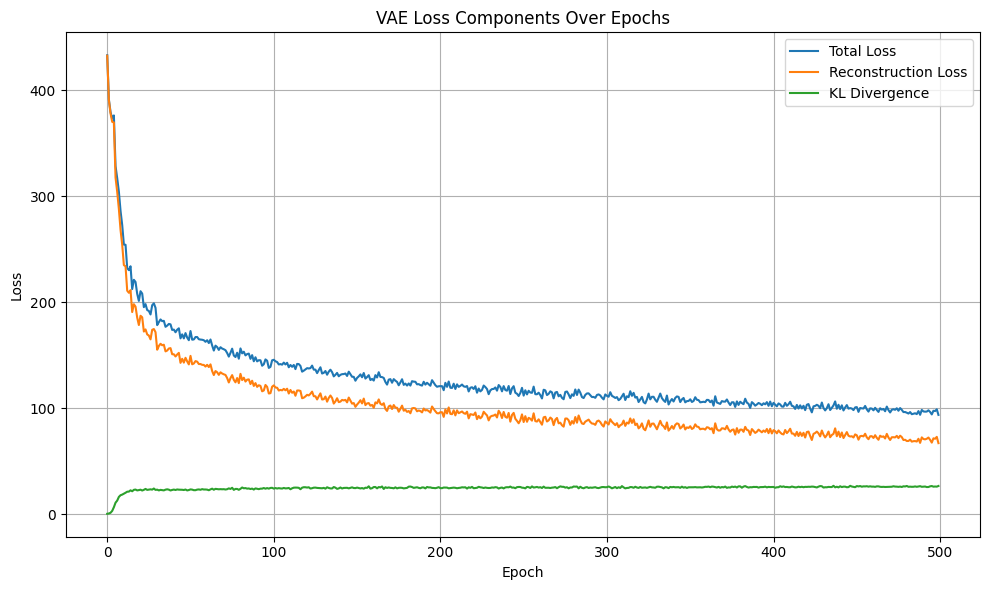

In [25]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

dim of latent mu: (331, 10)


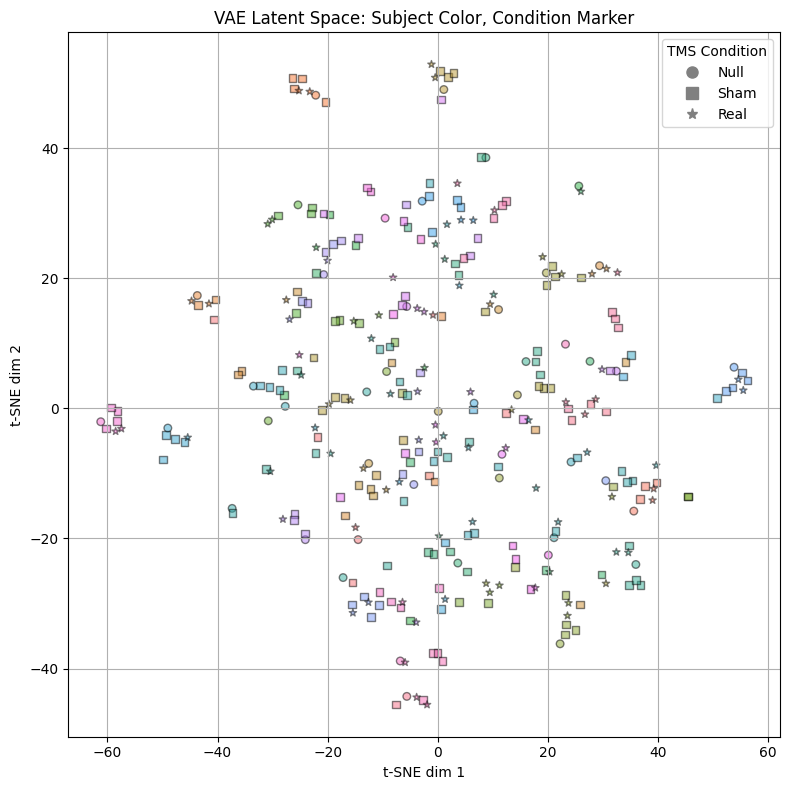

In [26]:
mu_all = get_latent_mu(model, X_tensor, device=device)
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

In [27]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)
print(df.head())
print(df.describe())

     subject  d_null_sham  d_null_real  diff_real_minus_sham
0  NODEAP_06     4.408054     5.699987              1.291933
1  NODEAP_07     5.002964     3.839171             -1.163792
2  NODEAP_08     3.367412     3.395081              0.027668
3  NODEAP_09     3.891701     3.387905             -0.503796
4  NODEAP_10     3.204814     2.467511             -0.737303
       d_null_sham  d_null_real  diff_real_minus_sham
count    46.000000    46.000000             46.000000
mean      4.025438     4.307514              0.282076
std       1.241114     1.374909              0.996970
min       1.769881     1.815746             -1.952935
25%       3.170992     3.369182             -0.443143
50%       3.631702     4.208599              0.340200
75%       4.996119     4.951287              1.036145
max       6.822613     7.668034              2.129267


Paired t-test: t = -1.919, p = 0.0613


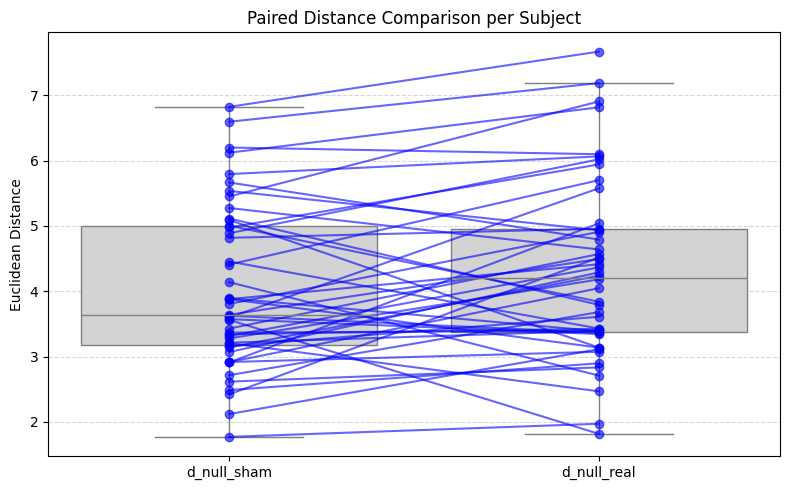

In [28]:
# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)